In [1]:
import glob
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
##########################################################
# Utility functions used in cleaning best-track dataframes
##########################################################

# Function to categorize cyclone into IMD classification 
# based on Maximum Sustained Wind Speed (MSWS)
def categorize_cyclone(wind_speed): 
    if wind_speed < 17:
        return "LPA"
    elif 17 <= wind_speed <= 27:
        return "D"
    elif 28 <= wind_speed <= 33:
        return "DD"
    elif 34 <= wind_speed <= 47:
        return "CS"
    elif 48 <= wind_speed <= 63:
        return "SCS"
    elif 64 <= wind_speed <= 89:
        return "VSCS"
    elif 90 <= wind_speed <= 119:
        return "ESCS"
    else:
        return "SUCS"

# Function to convert latitude and longitude from 
# "tenths of a degree with hemispheric index (E/W/N/S)" 
# to "degree with sign indicating hemisphere"
def convert_lat(lat):
    lat = lat.replace(' ','')
    if lat[-1] == 'N':
        return float(lat[0:-1])/10
    else:
        return -float(lat[0:-1])/10

def convert_lon(lon):
    lon = lon.replace(' ','')
    if lon[-1] == 'E':
        return float(lon[0:-1])/10
    else:
        return -float(lon[0:-1])/10

In [3]:
#####################################################
# Function containing steps to clean IMD BT data
#####################################################
def cleaning_df_imd(df):
    # Converting 'Maximum Sustained Surface Wind (kt) ' values to numeric and dropping NaN valued entries.
    df['Maximum Sustained Surface Wind (kt) '] = pd.to_numeric(df['Maximum Sustained Surface Wind (kt) '], errors='coerce')
    print("Dropped {} rows by cleaning \
          'Maximum Sustained Surface Wind (kt) ' column.".format(df['Maximum Sustained Surface Wind (kt) '].isna().sum()))
    df = df[df['Maximum Sustained Surface Wind (kt) '].notna()] 
    # Selecting all rows where 'Time (UTC)' is NOT NaN.
    print("Dropped {} rows by cleaning 'Time (UTC)' column.".format(df['Time (UTC)'].isna().sum()))
    df = df[df['Time (UTC)'].notna()]
    # Removing any whitespaces in the 'Basin of Origin' code.
    df['Basin of origin'] = df['Basin of origin'].str.replace(' ', '')

    # Selecting all rows that have 'Basin of origin' as the Arabian Sea (abbreviated as ARB or AS) 
    # or the Bay of Bengal (abbreviated as BOB).
    print("Dropped {} rows by cropping based on \
          'Basin of origin' entries.".format(df[(df['Basin of origin'] != 'ARB') & (df['Basin of origin'] != 'AS') 
                                                & (df['Basin of origin'] != 'BOB')].shape[0]))
    df = df[(df['Basin of origin'] == 'ARB') | (df['Basin of origin'] == 'AS') | (df['Basin of origin'] == 'BOB')] 
    # Keeping the abbreviation of entries (with 'Basin of Origin' as Arabian Sea specifically) consistent.
    df['Basin of origin'] = df['Basin of origin'].replace('ARB', 'AS')

    # Adding leading zeros to 'Time (UTC)' values to make it in format of HHMM.
    df['Time (UTC)'] = df['Time (UTC)'].astype('int').astype('str').str.zfill(4)
    # Convert 'Time (UTC)' to HH:MM format. 
    df['Time (UTC)'] = df['Time (UTC)'].apply(lambda x: f'{x[:2]}:{x[2:]}') 

    # Brute converting 'Date(DD-MM-YYYY)' column to datetime64[ns] format.
    df['Date(DD-MM-YYYY)'] = pd.to_datetime(df['Date(DD-MM-YYYY)']) 
    # Combining the 'Date(DD-MM-YYYY)' and 'Time (UTC)' columns into a new 'DATETIME' column.
    df['DATETIME'] = pd.to_datetime(df['Date(DD-MM-YYYY)'].dt.strftime('%Y-%m-%d') + ' ' + df['Time (UTC)'])
    # Brute converting 'DATETIME' column to datetime64[ns] format, just for the sake of it as a final measure.
    df['DATETIME'] = pd.to_datetime(df['DATETIME']) 
    # Setting 'DATETIME' as index.
    df.set_index('DATETIME', inplace = True) 

    # Making 'Serial Number of system during year' unique by modifying it to be a combination of year in 
    # which a cyclone happened and serial number (YYYYSS).
    df['Serial Number of system during year'] = (df['Serial Number of system during year'] + df.index.year*100).astype('int')
    # Removing any rows with either 'Latitude (lat.)' or 'Longitude (lon.)' as NaN values.
    print("Dropped {} rows by cleaning both 'Latitude (lat.)' and\
           'Longitude (lon.)' columns.".format((df['Latitude (lat.)'].isna() | df['Longitude (lon.)'].isna()).sum()))
    df = df[df['Latitude (lat.)'].notna() & df['Longitude (lon.)'].notna()]     
    # Dropping redundant columns
    df = df.drop(['Date(DD-MM-YYYY)', 'Time (UTC)'], axis = 1)

    # # Cleaning-up Grade classification to make it consistent
    # df = df.replace({'Grade (text)'  :   {'SuCS'    :'SUCS' ,
    #                                       '      D'  :'D',
    #                                       'D Over   land'   :'D', 
    #                                       'DD '     :'DD',
    #                                       'Cs'  :'CS'}})
    # # Removing any un-graded entries (very few stray entries were found)
    # print("Dropped {} rows by cleaning 'Grade (text)' column.".format(df['Grade (text)'].isna().sum()))
    # df = df[df['Grade (text)'].notna()]

    # Cropping out all the columns that aren't relevant for current analysis and renaming columns to a sensible name
    df = df[['Serial Number of system during year', 'Latitude (lat.)', 'Longitude (lon.)', 
             'Maximum Sustained Surface Wind (kt) ', 'Basin of origin']]#, 'Grade (text)']]
    df = df.rename(columns = {'Serial Number of system during year':'CS_ID', 
                              'Latitude (lat.)':'LAT', 
                              'Longitude (lon.)':'LON', 
                              'Maximum Sustained Surface Wind (kt) ':'MSWS', #'Grade (text)':'CAT',
                              'Basin of origin':'ORIGIN_BASIN'})
    
    # Creating a new column 'CAT' that categorizes entries based on 'MSWS' value, using categorize_cyclone() utility function
    df['CAT'] = df['MSWS'].astype(float).apply(categorize_cyclone)

    # Dropping any NaN valued entries from the dataframe.
    print("\nDropped rows with NaN \n {}".format(df.isna().sum()))
    df = df.dropna()

    # Sorting columns in alphabetical order
    df = df.reindex(sorted(df.columns), axis=1)

    # Cropping data between 1982-2023
    df = df[(df.index.year >= 1982) & (df.index.year <= 2023)]

    return df

#####################################################
# Function containing steps to clean JTWC BT data
#####################################################
def cleaning_df_jtwc(df):
    # Formatting 'YYYYMMDDHH' datetime column to datetime[ns] type, renaming it to 'DATETIME' and setting it as index of df
    df['YYYYMMDDHH'] = pd.to_datetime(df['YYYYMMDDHH'], format = '%Y%m%d%H')
    df = df.rename(columns = {'YYYYMMDDHH':'DATETIME'})
    df.set_index('DATETIME', inplace = True)
    df.sort_index(inplace = True)
    
    # Selecting data for the 'SUBREGION' of Arabian Sea ('A') and Bay of Bengal ('B')
    df = df[(df['SUBREGION'] == '  A') | (df['SUBREGION'] == '  B')]
    # Replacing basin codes to keep it consistent across different datasets.
    df['SUBREGION'] = df['SUBREGION'].str.replace(' A', 'AS') 
    df['SUBREGION'] = df['SUBREGION'].str.replace(' B', 'BOB')

    # Removing unwanted whitespaces from 'SUBREGION' entries.
    df['SUBREGION'] = df['SUBREGION'].str.replace(' ', '')

    # Selecting only columns that are relavant for our analysis
    df = df[['CY', 'LatN/S', 'LonE/W', 'VMAX', 'SUBREGION']]

    # Making unique serial number for each cyclone as a combination of year and index of cyclone 
    # in a particular year (in YYYYCY format)
    df['CS_ID'] = df.index.year*100 + df['CY'].astype('int')
    # Dropping index of cyclone in a particular year('CY') column as it's not needed anymore
    df = df.drop('CY', axis = 1) 

    # Apply the categorize_cyclone function to each row in the dataframe
    df['CAT'] = df['VMAX'].astype(float).apply(categorize_cyclone)
    df['LatN/S'] = df['LatN/S'].apply(convert_lat)
    df['LonE/W'] = df['LonE/W'].apply(convert_lon)

    # Setting type of 'VMAX' sustained wind speed as float
    df['VMAX'] = df['VMAX'].astype(float)

    # Renaming columns to a sensible name
    df = df.rename(columns = {'LatN/S':'LAT', 'LonE/W':'LON', 'VMAX':'MSWS', 'SUBREGION':'ORIGIN_BASIN'})

    # Dropping any NaN valued entries from the dataframe.
    print("\nDropped rows with NaN \n {}".format(df.isna().sum()))
    df = df.dropna()

    # Sorting columns in alphabetical order
    df = df.reindex(sorted(df.columns), axis=1)

    # Cropping data between 1982-2023
    df = df[(df.index.year >= 1982) & (df.index.year <= 2023)]

    return df


#####################################################
# Function containing steps to clean IBTrACS BT data
#####################################################

def cleaning_df_ibtracs(df):
    # Selecting 'SUBBASIN' to be either Arabian Sea ('AS') or Bay of Bengal ('BB'), also selecting only Tropical Storms ('TS')
    df = df[((df['SUBBASIN'] == 'AS') | (df['SUBBASIN'] == 'BB')) & (df['NATURE'] == 'TS')]

    # Replacing basin codes to keep it consistent across different datasets.
    df['SUBBASIN'] = df['SUBBASIN'].str.replace('BB', 'BOB')

    # Selecting only columns that are relavant for our analysis
    df = df[['ISO_TIME', 'WMO_WIND', 'LAT', 'LON', 'SID', 'SUBBASIN']]
    # Renaming columns to sensible names
    df = df.rename(columns = {'ISO_TIME':'DATETIME', 'WMO_WIND':'MSWS', 'SID':'CS_ID', 'SUBBASIN':'ORIGIN_BASIN'})

    # Changing 'DATETIME' format to datetime64[ns] and setting it as the dataframe index.
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    df.set_index('DATETIME', inplace = True)

    # Converting 'Maximum Sustained Surface Wind (kt) ' values to numeric and dropping NaN valued entries.
    df.loc[:,'MSWS'] = pd.to_numeric(df['MSWS'], errors='coerce')
    # Drop rows where the 'WMO_WIND' has NaN values (i.e., non-integer values)
    df = df.dropna(subset=['MSWS'])
    df.loc[:,'MSWS'] = df['MSWS'].astype(int)

    # Creating a new column 'CAT' that categorizes entries based on 'MSWS' value, using categorize_cyclone() utility function
    df['CAT'] = df['MSWS'].astype(float).apply(categorize_cyclone)

    # Dropping any NaN valued entries from the dataframe.
    print("\nDropped rows with NaN \n {}".format(df.isna().sum()))
    df = df.dropna()

    # Sorting columns alphabetically
    df = df.reindex(sorted(df.columns), axis=1)

    # Cropping data between 1982-2023
    df = df[(df.index.year >= 1982) & (df.index.year <= 2023)]

    return df

----

## IMD Data
**Data downloaded from:**<br>
https://rsmcnewdelhi.imd.gov.in/download.php?path=uploads/best-track/58cc0f_Best%20Tracks%20Data%20(1982-2023)_COR_updated.xls<br>
<br>
**Documentation available:**<br>
https://rsmcnewdelhi.imd.gov.in/download.php?path=uploads/report/bestrack.pdf <br>
https://rsmcnewdelhi.imd.gov.in/report.php?internal_menu=MzM=

In [4]:
# Reading in the raw data, which is in the form of an Excel file. The file consists of different sub-sheets for each year (under the name of the year itself)

# NOTE: This .xls was modified natively on Excel to make it easy for further preprocessing steps. These modifications include correcting a few timestamps,
# unmerging cells, making sure column names are consistent across different sub-sheets, correcting any format errors in datetime and other quantities,
# and, overall, checking if the data format and the way it is stored is consistent across different sheets of the .xls file.

df_bt_imd =pd.read_excel('./raw_data/imd/58cc0f_Best Tracks Data (1982-2024)_COR_updated.xls', sheet_name=[str(y) for y in range(1982,2025)])

In [5]:
df = [] # List to store all the dataframes of each year. 
for y in range(1982,2025):
      try:
              df = df +[df_bt_imd[str(y)]]
      except:
             print(y)
df = pd.concat(df) # Concatenating all the yearly dataframes into a single dataframe

df = cleaning_df_imd(df) # Cleaning the concatenated dataframe

Dropped 1693 rows by cleaning           'Maximum Sustained Surface Wind (kt) ' column.
Dropped 0 rows by cleaning 'Time (UTC)' column.
Dropped 253 rows by cropping based on           'Basin of origin' entries.
Dropped 28 rows by cleaning both 'Latitude (lat.)' and           'Longitude (lon.)' columns.

Dropped rows with NaN 
 CS_ID           0
LAT             0
LON             0
MSWS            0
ORIGIN_BASIN    0
CAT             0
dtype: int64


In [6]:
# Saving the processed file
df.to_csv('./processed/IMD_TCBT_AS_BOB_1982-2023.csv')
del df

---

## JTWC Data
**Data downloaded from:**<br>
https://www.metoc.navy.mil/jtwc/jtwc.html?north-indian-ocean<br>
<br>
**Documentation available:**<br>
https://www.metoc.navy.mil/jtwc/jtwc.html?north-indian-ocean<br>

In [7]:
# Reading in the raw data files' names
fnames_jtwc_raw_data = sorted(glob.glob('./raw_data/jtwc/*'))

# Creating a dummy dataframe with column names based on the 'documentation'/website of JTWC from where this best track data has been downloaded.
df = pd.DataFrame(columns = ['BASIN' , 'CY' , 'YYYYMMDDHH' , 'TECHNUM' , 'TECH' , 'TAU' , 'LatN/S' , 'LonE/W' , 'VMAX' , 'MSLP' ,
'TY' , 'RAD' , 'WINDCODE' , 'RAD1' , 'RAD2' , 'RAD3' , 'RAD4' , 'RADP' , 'RRP' , 'MRD' , 'GUSTS' , 'EYE' ,
'SUBREGION' , 'MAXSEAS' , 'INITIALS' , 'DIR' , 'SPEED' , 'STORMNAME' , 'DEPTH' , 'SEAS' ,
'SEASCODE' , 'SEAS1' , 'SEAS2' , 'SEAS3' , 'SEAS4'])

In [8]:
# Reading in the datafiles (which are in the form of .txt or .dat) into the above defined dataframe
for f in fnames_jtwc_raw_data:
    with open(f) as file:
        lines = [line.rstrip() for line in file] # Stripping each line from the file and saving it as a list.
    for x in lines:
        lst = x.split(', ')[0:35] 
        # NOTE: The 'documentation' states that there are 35 columns, however some years had more than that.
        # As the columns that are relevant for our work are within the first 35 columns, I've cropped out
        # any data entries list that exceed 35 in size. Hence the above line.
        new_row =  lst + [np.nan] * (35 - len(lst)) # Fill in with NaN if the number of entries is less than 35.
        df.loc[len(df)] = new_row

In [9]:
# Cleaning the dataframe
df = cleaning_df_jtwc(df)

# Saving the processed dataframe as a .csv
df.to_csv('./processed/JTWC_TCBT_AS_BOB_1982-2023.csv')
del df


Dropped rows with NaN 
 LAT             0
LON             0
MSWS            0
ORIGIN_BASIN    0
CS_ID           0
CAT             0
dtype: int64


----

## IBTrACS Data
**Data downloaded from:**<br>
https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/csv/<br>
<br>
**Documentation available:**<br>
https://www.ncei.noaa.gov/sites/g/files/anmtlf171/files/2023-07/IBTrACS_version4r01_Technical_Details.pdf <br>
https://www.ncei.noaa.gov/sites/g/files/anmtlf171/files/2023-06/IBTrACS%20v04r01%20column%20documentation.pdf

In [10]:
# Reading in the raw data
df = pd.read_csv('./raw_data/ibtracs/ibtracs.NI.list.v04r01.csv', low_memory=False)
df = df.iloc[1:] # Reading from the second row as the first row contains 'units' name for some of the columns.


In [11]:
# Cleaning the dataframe
df = cleaning_df_ibtracs(df)


Dropped rows with NaN 
 MSWS            0
LAT             0
LON             0
CS_ID           0
ORIGIN_BASIN    0
CAT             0
dtype: int64


/var/folders/3t/w3vt3f7s745cdpdml8l8wtl00000gp/T/ipykernel_15424/1412457871.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SUBBASIN'] = df['SUBBASIN'].str.replace('BB', 'BOB')


In [12]:
df.to_csv('./processed/IBTrACS_TCBT_AS_BOB_1982-2023.csv')
del df

---

## Visualizing Best Tracks after data pre-processing

In [13]:
##### PLOTTING TC BEST TRACKS AFTER PROCESSING FOR VISUALIZATION #####
def bt_plotter(datasource):
    df =pd.read_csv('./processed/{}_TCBT_AS_BOB_1982-2023.csv'.format(datasource))
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    df.set_index('DATETIME', inplace = True)
    
    fig = plt.figure(figsize=(24, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.set_extent([50, 100, 5, 30], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)


    for y in range(1982,2023):
        tc_bt_data = df[df.index.year == y]
        # Plot each cyclone's track
        for serial in sorted(list(set(tc_bt_data['CS_ID'].values))):
            latitudes = tc_bt_data[tc_bt_data['CS_ID'] == serial]['LAT'].values.astype('float')
            longitudes = tc_bt_data[tc_bt_data['CS_ID'] == serial]['LON'].values.astype('float')
            
            # Plot the track
            ax.plot(longitudes, latitudes, label=f'Serial {str(serial)}')

    # Add a legend
    #ax.legend(title='Cyclone Serial Numbers', loc='upper left')

    # Display the plot
    fig.suptitle(datasource+' | Best Tracks of Tropical Cyclones in the Arabian Sea & Bay of Bengal | 1982-2023', fontsize = 21, fontweight = 'bold')
    plt.show()


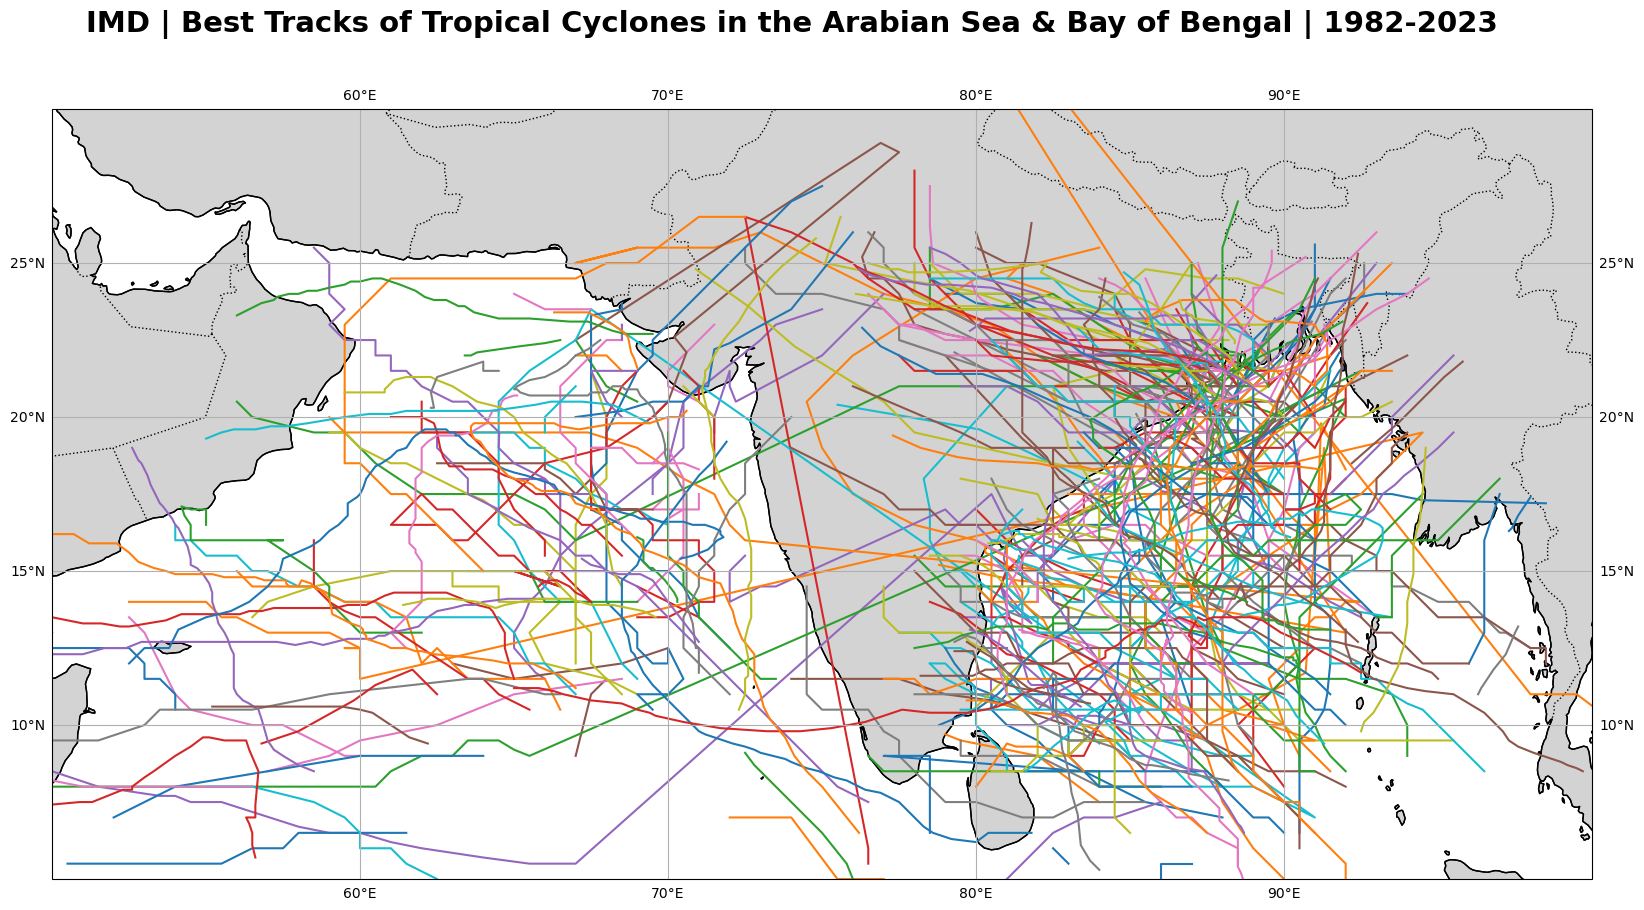

In [14]:
bt_plotter(datasource = 'IMD')

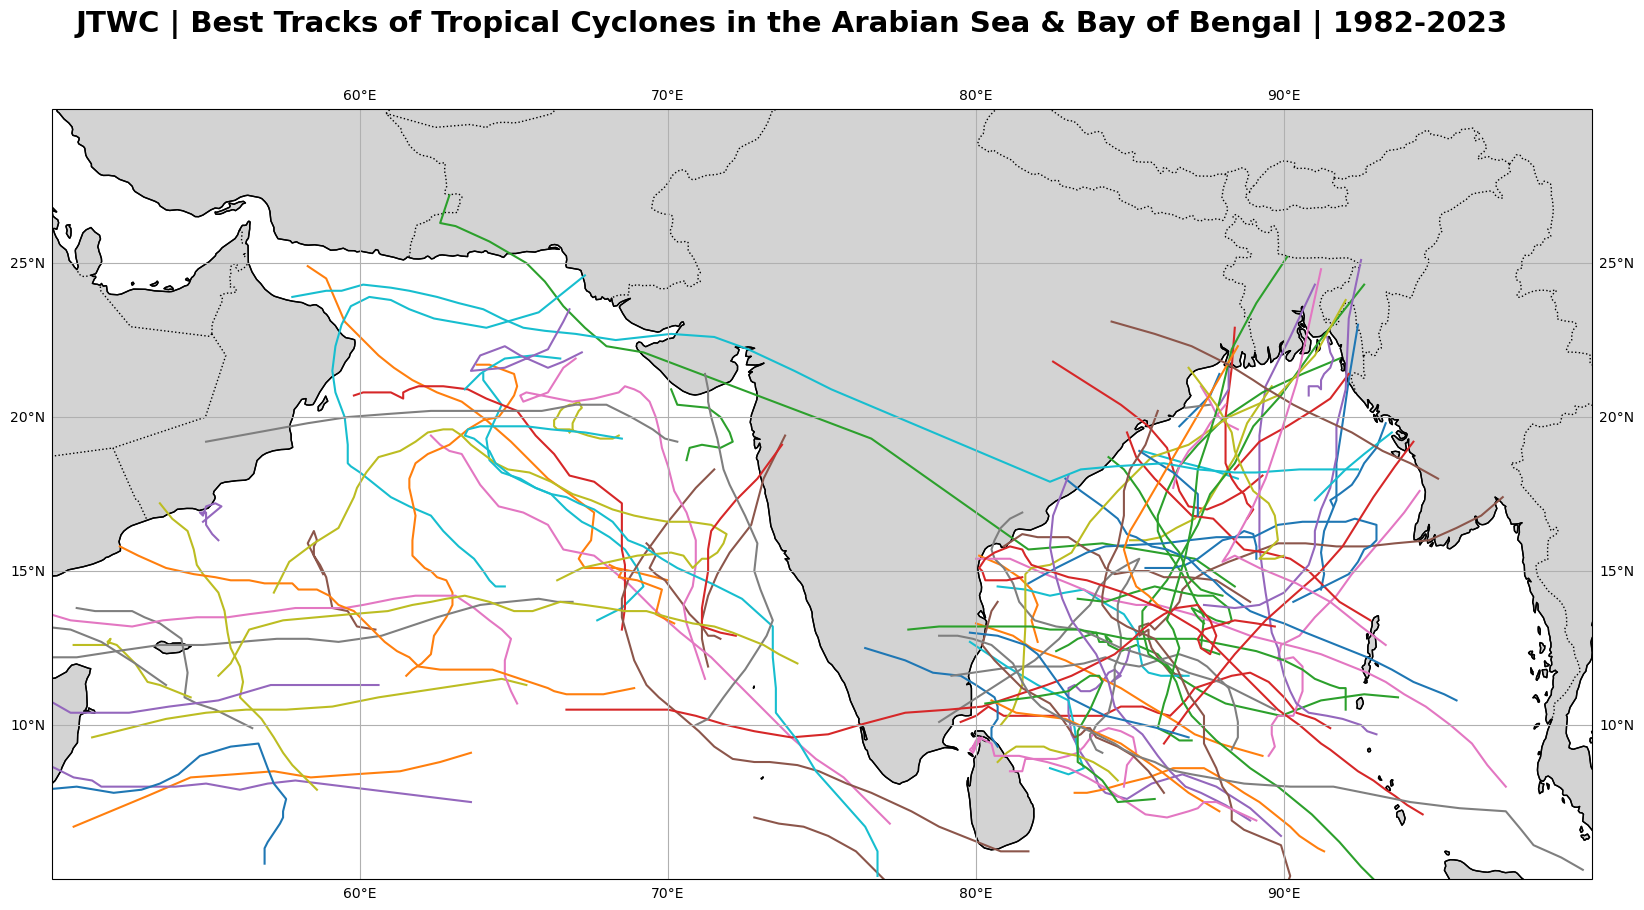

In [15]:
bt_plotter(datasource = 'JTWC')

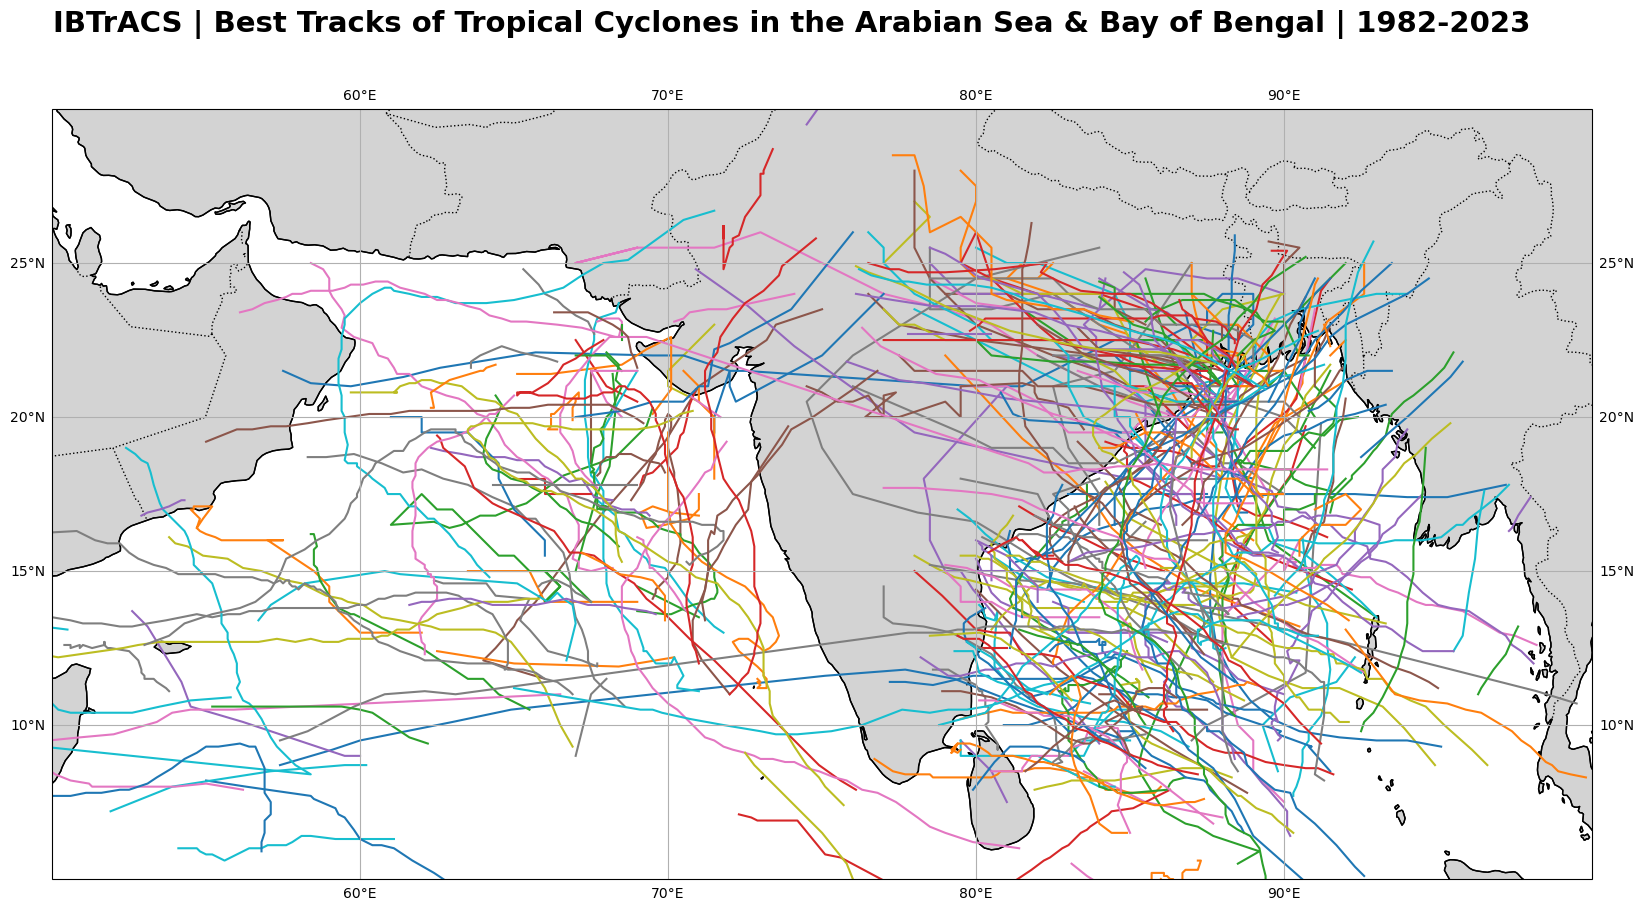

In [16]:
bt_plotter(datasource = 'IBTrACS')

----